In [72]:
import time, sys, joblib

import pandas as pd

sys.path.append('/home/yilingh/SI-Interaction')
from selectinf.Simulation.plotting_helpers import *
from selectinf.Simulation.H1.nonlinear_H1_helpers import *

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
sns.set_style("white", {'axes.facecolor': 'white',
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                            })

from operator import le, ge
def filter_pval_dict_new(target_dict, threshold=0.05, operator=le, p_flag="pivot"):
    grouped_targets = pd.DataFrame(target_dict).groupby(['parameter', 'method'])
    filtered_dict = {}
    # Filter by 
    for name, group in grouped_targets:
        # Subset the selected targets
        selected_targets_id = operator(np.abs(group['target']), threshold)
        selected_targets = group[p_flag][selected_targets_id]
        # Then filtered_dict.keys must be a dictionary
        if name[0] in filtered_dict.keys():
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        else:
            filtered_dict[name[0]] = {}
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        
    return filtered_dict


def combine_dicts(dict, new_dict):
    for key in dict.keys():
        dict[key] = dict[key] + new_dict[key]

    return dict


def combine_nested_dicts(dict, new_dict):
    combined_dict = {}
    for key in dict.keys():
        combined_dict[key] = combine_dicts(dict[key], new_dict[key])

    return combined_dict

In [117]:
n_task_per_file = 100
n_files = 10
base_dir_corr = "../vary_corr/vary_corr_"
base_dir_signal = "../vary_signal/vary_signal_"
base_dir_inter = "../vary_interaction/vary_interaction_"
base_dir_sparsity = "../vary_sparsity/vary_sparsity_"
files_list_corr = []
files_list_signal = []
files_list_inter = []
files_list_sparsity = []
for i in range(n_files):
    dir_corr = base_dir_corr + str(i*n_task_per_file) + "_"  + str((i+1)*n_task_per_file) + ".pkl"
    dir_signal = base_dir_signal + str(i*n_task_per_file) + "_"  + str((i+1)*n_task_per_file) + ".pkl"
    dir_inter = base_dir_inter + str(i*n_task_per_file) + "_"  + str((i+1)*n_task_per_file) + ".pkl"
    dir_sparsity = base_dir_sparsity + str(i*n_task_per_file) + "_"  + str((i+1)*n_task_per_file) + ".pkl"
    files_list_corr.append(dir_corr)
    files_list_signal.append(dir_signal)
    files_list_inter.append(dir_inter)
    files_list_sparsity.append(dir_sparsity)

In [118]:
def combine_sim_output(files_list):
    oper_char_full = None
    ds_rank_def_count_full = None
    target_dict_full = None
    pval_dict_full = None
    MSE_dict_full = None
    F1_dict_full = None
    
    for path in files_list:
        ds_rank_def_count, target_dict, pval_dict, MSE_dict, oper_char, F1_dict = joblib.load(path)
        # Combine ds_rank_def_count
        if not ds_rank_def_count_full:
            ds_rank_def_count_full = ds_rank_def_count
        else:
            ds_rank_def_count_full = combine_dicts(ds_rank_def_count_full, ds_rank_def_count)
        # Combine target_dict
        if not target_dict_full:
            target_dict_full = target_dict
        else:
            target_dict_full = combine_dicts(target_dict_full, target_dict)
        if not pval_dict_full:
            pval_dict_full = pval_dict
        else:
            pval_dict_full = combine_nested_dicts(pval_dict_full, pval_dict)
        # Combine MSE_dict
        if not MSE_dict_full:
            MSE_dict_full = MSE_dict
        else:
            MSE_dict_full = combine_dicts(MSE_dict_full, MSE_dict)
        # Combine oper_char
        if not oper_char_full:
            oper_char_full = oper_char
        else:
            oper_char_full = combine_dicts(oper_char_full, oper_char)
        if not F1_dict_full:
            F1_dict_full = F1_dict
        else:
            F1_dict_full = combine_dicts(F1_dict_full, F1_dict)
            
    return (oper_char_full, ds_rank_def_count_full, target_dict_full, pval_dict_full,
            MSE_dict_full, F1_dict_full)

In [119]:
corr_results = combine_sim_output(files_list_corr)

In [120]:
signal_results = combine_sim_output(files_list_signal)

In [121]:
inter_results = combine_sim_output(files_list_inter)

In [122]:
sparsity_results = combine_sim_output(files_list_sparsity)

In [123]:
def plot_ecdfs(data_dict, xaxis=None, title=None):
    """
    Plot an ECDF for each rho value with different methods overlayed, using a single shared legend.

    Parameters:
    - data_dict: dict, a nested dictionary with structure {rho: {method: [values]}}
    """
    # Define colors for each method
    my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

    def ecdf(data):
        """Compute ECDF for a one-dimensional array of measurements."""
        n = len(data)
        x = np.sort(data)
        y = np.arange(1, n + 1) / n
        return x, y

    num_rho = len(data_dict)
    # Create subplots
    fig, axes = plt.subplots(1, num_rho, figsize=(4 * num_rho, 4), facecolor="w")
    # In case there's only one subplot, wrap it in a list for consistency.
    if num_rho == 1:
        axes = [axes]

    # Plot ECDFs in each subplot
    for ax, (signal, methods) in zip(axes, data_dict.items()):
        for method, values in methods.items():
            # Map "MLE" to "Proposed"
            label = "Proposed" if method == "MLE" else method
            x, y = ecdf(values)
            ax.plot(x, y, marker='.', linestyle='none',
                    color=my_palette[method], label=label)

        # Plot reference line y = x
        max_value = max(max(vals) for vals in methods.values())
        ax.plot([0, max_value], [0, 1], 'k--', label='y=x')

        # Set subplot title and axes labels
        ax.set_title(f'{xaxis} = {signal}', fontsize=16)
        ax.set_xlabel('x', fontsize=16)
        ax.set_ylabel(r'$\widehat{F}(x)$', fontsize=16)
        # Make the current subplot square: one unit on x is equal to one unit on y.
        ax.set_aspect('equal', adjustable='box')
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.grid(True)

    # Extract legend handles and labels from one axis (e.g., the first one)
    handles, labels = axes[0].get_legend_handles_labels()

    # Remove duplicates while preserving order.
    seen = set()
    unique_handles_labels = []
    for handle, label in zip(handles, labels):
        if label not in seen:
            unique_handles_labels.append((handle, label))
            seen.add(label)
    unique_handles, unique_labels = zip(*unique_handles_labels)

    # Create a single, global legend
    fig.legend(unique_handles, unique_labels, loc='upper center', ncol=len(unique_labels),
               fontsize=16, title_fontsize=16,
               bbox_to_anchor=(0.5, 0.0))

    if title is not None:
        fig.suptitle(title, fontsize=16)

    # Adjust layout so that the legend and title don't overlap with subplots
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.style.use('default')
    #
    plt.show()

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def plot_ecdfs_all(data_dicts, xaxes=None, title=None):
    """
    Plot ECDFs for each provided dictionary on its own row of subplots.
    Each dictionary in data_dicts should have a nested dictionary structure:
        {rho: {method: [values]}}
    where each row (each dict in data_dicts) will be plotted in a separate row.
    
    Parameters:
    - data_dicts: list (or tuple) of dicts. Expected to have 4 dictionaries.
    - xaxes: list of row titles. Each entry is used as the title for the corresponding row.
    - title: overall title for the figure.
    """
    my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
    
    sns.set_style("white", {'axes.facecolor': 'white',
                             'axes.grid': True,
                             'axes.linewidth': 2.0,
                             'grid.linestyle': '--',
                             'grid.linewidth': 4.0,
                             'xtick.major.size': 5.0})
    
    def ecdf(data):
        """Compute ECDF for a one-dimensional array of measurements."""
        data = np.array(data)
        n = len(data)
        x_sorted = np.sort(data)
        y = np.arange(1, n + 1) / n
        return x_sorted, y

    num_rows = len(data_dicts)
    # Determine the maximum number of keys across all dictionaries (number of subplots per row)
    num_cols = max(len(d) for d in data_dicts)
    
    # Create an outer GridSpec that has one column and one row per data_dict.
    # Each row in this outer GridSpec will be further split into two rows:
    # a narrow row for the title and a main row for the subplots.
    outer = GridSpec(nrows=num_rows, ncols=1, hspace=0.4)
    # Adjust the overall figure size as needed. Note the extra factor in height to accommodate titles.
    fig = plt.figure(figsize=(4 * num_cols, 4 * num_rows * 1.2), facecolor="w")
    
    first_ax = None  # We'll store the first actual subplot for legend extraction later.
    
    # Loop over each data_dict (each outer GridSpec "row")
    for i, data_dict in enumerate(data_dicts):
        # Create an inner GridSpec for this row with 2 rows and num_cols columns.
        # The height ratios allocate less space to the top row (for the title) than to the plot row.
        inner = GridSpecFromSubplotSpec(nrows=2, ncols=num_cols, 
                                         subplot_spec=outer[i],
                                         height_ratios=[0.1, 1],
                                         hspace=0.1)
        
        # Create the row title axis spanning all columns in the first (narrow) row.
        ax_title = fig.add_subplot(inner[0, :])
        ax_title.axis('off')  # No axis lines or ticks here.
        # Use xaxes[i] as the row title if provided; otherwise, fallback.
        row_title = f"Setting {i+1}"
        ax_title.set_title(row_title, fontsize=18, weight='bold', pad=10)
        
        # Now create the subplots for this row in the second (main) row of the inner GridSpec.
        for j, (par, methods) in enumerate(data_dict.items()):
            ax = fig.add_subplot(inner[1, j])
            # Plot the ECDF for each method in this subplot.
            for method, values in methods.items():
                # Rename "MLE" to "Proposed"
                label = "Proposed" if method == "MLE" else method
                x_vals, y_vals = ecdf(values)
                ax.plot(x_vals, y_vals, marker='.', linestyle='none',
                        color=my_palette[method], label=label)
            
            # Plot the reference line y = x
            max_value = max(max(vals) for vals in methods.values())
            ax.plot([0, max_value], [0, 1], 'k--', label='y=x')
            
            # Set subplot title and axis labels
            ax.set_title(f'{xaxes[i]} = {par}', fontsize=15)
            ax.set_xlabel('x', fontsize=15)
            ax.set_ylabel(r'$\widehat{F}(x)$', fontsize=15)
            ax.set_aspect('equal', adjustable='box')
            ax.tick_params(axis='both', which='major', labelsize=13)
            ax.grid(True)
            
            if first_ax is None:
                first_ax = ax  # store the first plotted axis for legend extraction
        
        # Hide any extra subplots in this row if the dictionary has fewer keys than num_cols
        for j in range(len(data_dict), num_cols):
            ax = fig.add_subplot(inner[1, j])
            ax.set_visible(False)
    
    # Create a single global legend using the handles and labels from the first plotted axis.
    handles, labels = first_ax.get_legend_handles_labels()
    seen = set()
    unique_handles_labels = []
    for handle, label in zip(handles, labels):
        if label not in seen:
            unique_handles_labels.append((handle, label))
            seen.add(label)
    unique_handles, unique_labels = zip(*unique_handles_labels)
    
    # Place the legend at the top center of the overall figure.
    fig.legend(unique_handles, unique_labels, loc='upper center', ncol=len(unique_labels),
               fontsize=16, title_fontsize=16, bbox_to_anchor=(0.5, 0.075),
               markerscale=2)
    
    if title is not None:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.style.use('default')
    plt.show()


In [125]:
filtered_dict_signal = filter_pval_dict_new(signal_results[2], threshold = 0,
                                     operator=ge)
filtered_dict_corr = filter_pval_dict_new(corr_results[2], threshold = 0,
                                     operator=ge)
filtered_dict_inter = filter_pval_dict_new(inter_results[2], threshold = 0,
                                     operator=ge)
filtered_dict_sparsity = filter_pval_dict_new(sparsity_results[2], threshold = 0,
                                     operator=ge)

/var/folders/6t/y2p8qwk54f7fnkwds613w0040000gs/T/ipykernel_84893/964677213.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


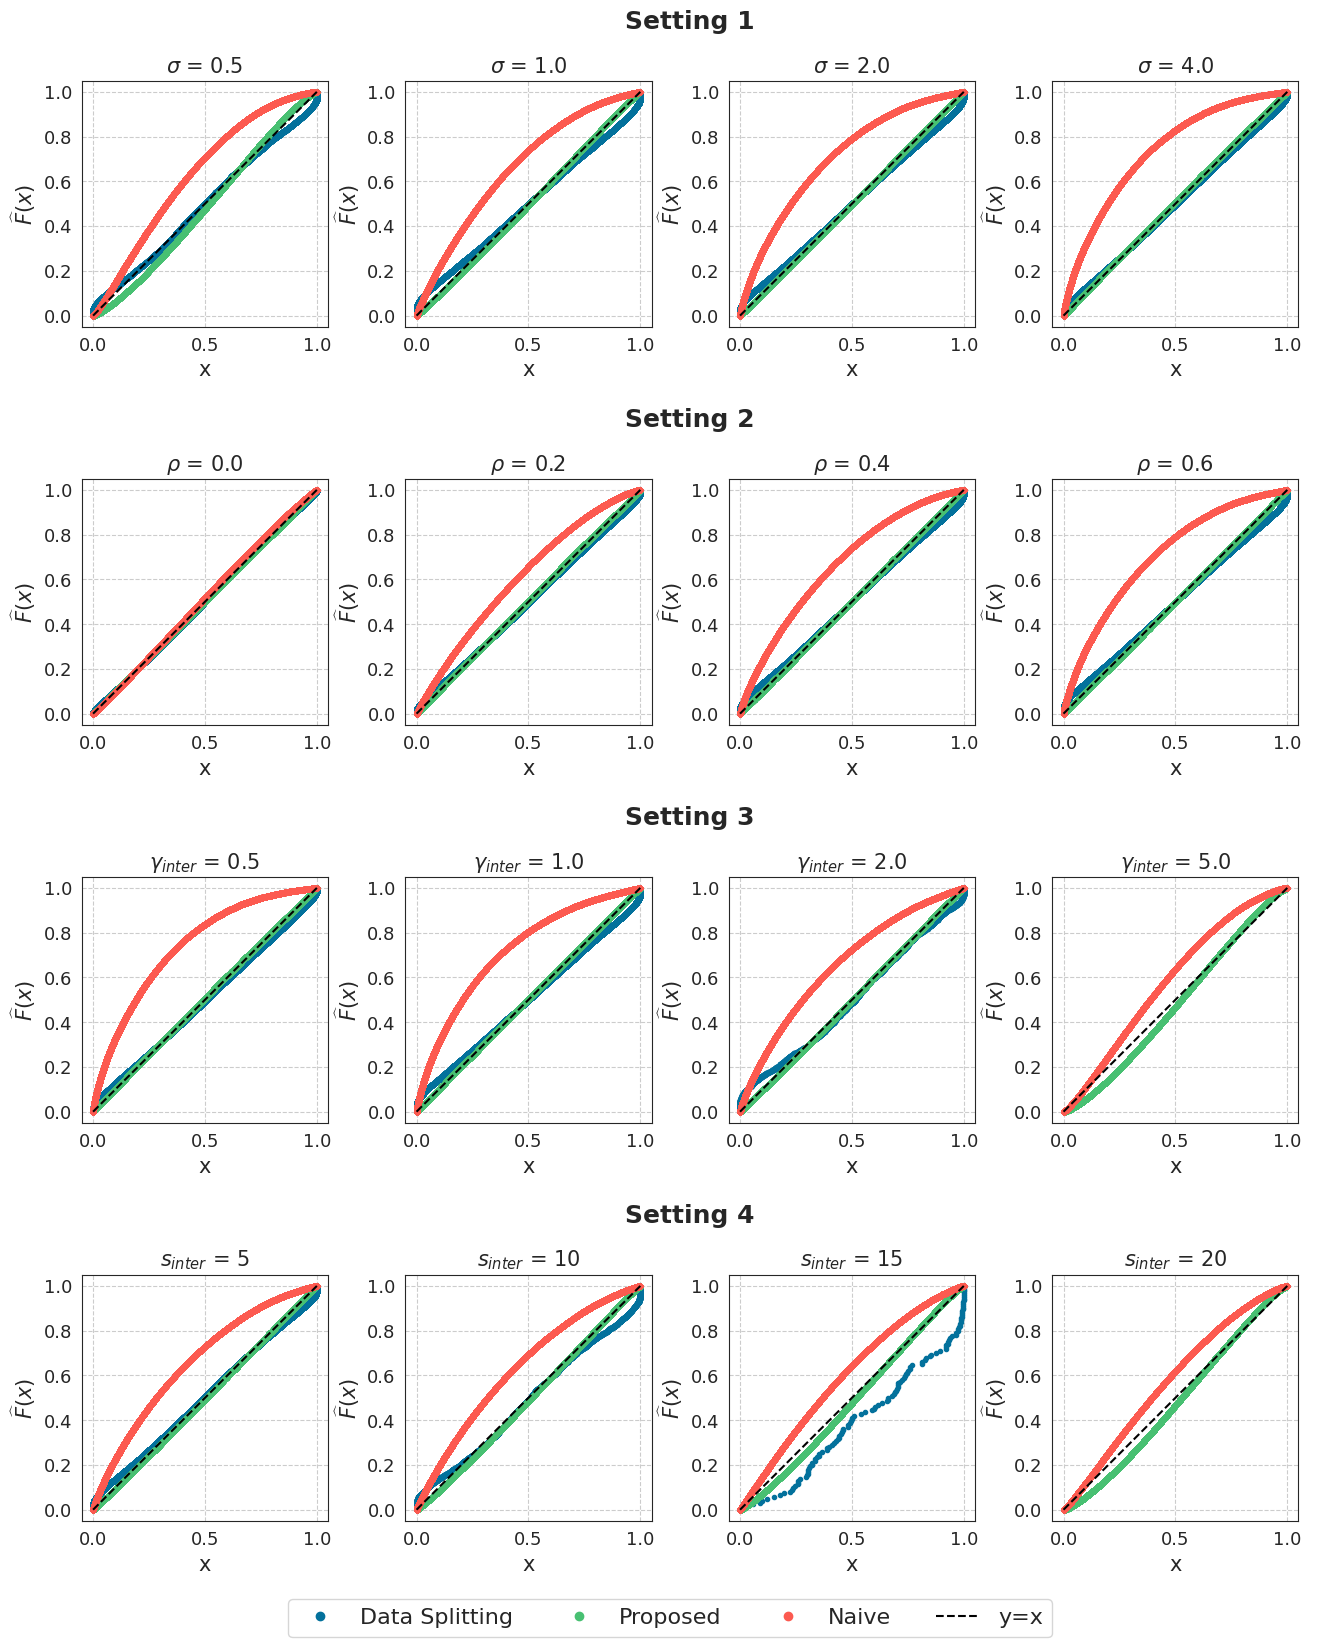

In [130]:
plot_ecdfs_all(data_dicts=[filtered_dict_signal, filtered_dict_corr, 
                           filtered_dict_inter, filtered_dict_sparsity],
               xaxes=[r"$\sigma$", r"$\rho$", r"$\gamma_{inter}$", r"$s_{inter}$"])

In [156]:
def plot_len_all(oper_char_full_df_list, xlabels, xaxes):
    # Suppose you have two dataframes (or two subsets of your data)
    # Here, I'm using oper_char_full_df for the first plot and oper_char_subset_df for the second.
    # If you use the same dataframe for both, adjust accordingly.

    # Define the palette
    my_palette = {"Proposed": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
    
    sns.set_style("white", {'axes.facecolor': 'white',
                                'axes.grid': True,
                                'axes.linewidth': 2.0,
                                'grid.linestyle': u'--',
                                'grid.linewidth': 4.0,
                                'xtick.major.size': 5.0,
                                })

    # Create a figure with two subplots (side by side)
    fig, axes = plt.subplots(1, len(oper_char_full_df_list), 
                             figsize=(3*len(oper_char_full_df_list), 4))

    for i, oper_char_full_df in enumerate(oper_char_full_df_list):
        oper_char_full_df.replace({'method': {"MLE": "Proposed"}}, inplace=True)
        # First pointplot on the left subplot:
        sns.pointplot(x=oper_char_full_df[xaxes[i]],
                      y=oper_char_full_df["avg length"],
                      hue=oper_char_full_df["method"],
                      markers='o',
                      palette=my_palette,
                      ax=axes[i],
                      legend=True if i == 0 else False)  # Disable automatic legend
    
        axes[i].set_ylabel("Average Length", fontsize=15)
        axes[i].set_xlabel(f"{xlabels[i]}", fontsize=15)
        axes[i].set_title(f"Setting {i+1}", fontsize=15, weight='bold', pad=10)
        axes[i].tick_params(axis='both', which='major', labelsize=13)

    # Now, create a single global legend.
    # We'll extract the handles and labels from one of the axes (since both share the same palette & labels).
    handles, labels = axes[0].get_legend_handles_labels()
    # Remove the legend from the first subplot (so it doesn't appear there)
    axes[0].legend_.remove()

    # Place the legend above the subplots, centered horizontally.
    fig.legend(handles, labels, loc='upper center', ncol=len(labels),
               title="Method", bbox_to_anchor=(0.5, 0), fontsize=15, title_fontsize=15)

    # Adjust layout so that subplots and the global legend don’t overlap.
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

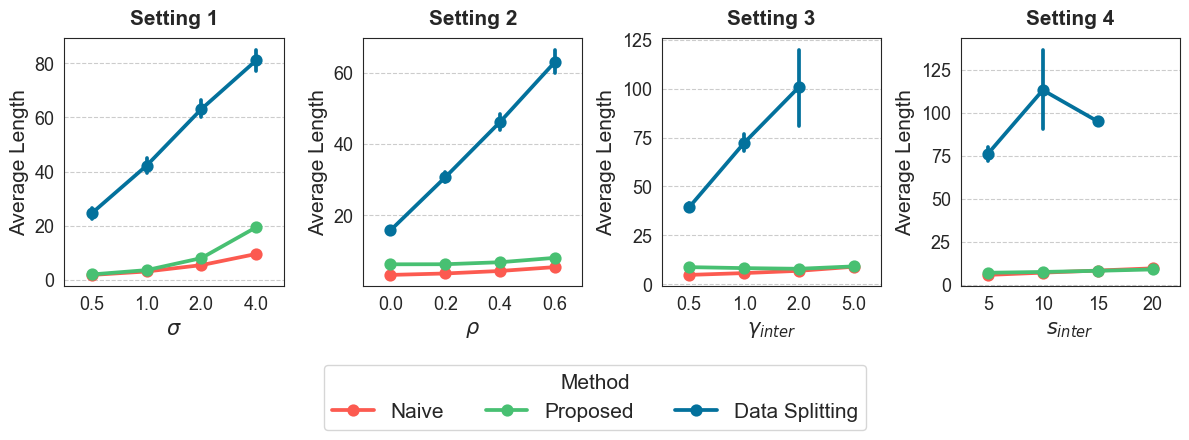

In [157]:
plot_len_all(oper_char_full_df_list=[pd.DataFrame(signal_results[0]), 
                                     pd.DataFrame(corr_results[0]),
                                     pd.DataFrame(inter_results[0]), 
                                     pd.DataFrame(sparsity_results[0])],
             xlabels=[r"$\sigma$", r"$\rho$", r"$\gamma_{inter}$", r"$s_{inter}$"],
             xaxes=["sd_y", "rho", "inter signal", "size"])

In [141]:
def calculate_metrics(pvalue, targets, level, type, threshold=0.05):
    # Type = "Total", "Rej", "NonNull", "TP", "TN", "FP", "FN" 
    pvalue = np.array(pvalue)
    targets = np.array(targets)
    non_null = np.abs(targets) >= threshold
    rejection = pvalue < level
    null = np.abs(targets) < threshold
    acceptance = pvalue >= level
    TP = np.sum(non_null * rejection)
    FP = np.sum(null * rejection)
    TN = np.sum(null * acceptance)
    FN = np.sum(non_null * acceptance)
    
    prec = TP/(TP + FP) if (np.sum(rejection) > 0) else 0
    recall = TP/(TP + FN) if (TP + FN > 0) else 0
    FDR = FP/(TP + FP) if (np.sum(rejection) > 0) else 0
    FPR = FP/(FP + TN) if (FP + TN > 0) else 0
    def E(s, p):
        return -np.sqrt((1-2*p)**2/4-2*s)-(1-2*p)/2
    if type == "Prec":
        return prec
    if type == "Recall":
        return recall
    if type == "FDR":
        return FDR
    if type == "FPR":
        return FPR
    if type == "F1":
        return 2 * prec * recall / (prec + recall) if (prec * recall != 0) else 0
    if type == "N_rej":
        return np.sum(rejection)
        

def calculate_metric_df(targets_dict,
                          threshold=0.1,
                          level=0.1,
                          pval_key="pvals",
                        metric_list = ["Prec", "Recall", "FDR", "NonNull/Total"],
                        rank_def_count=None):
    grouped_targets = pd.DataFrame(targets_dict).groupby(['index',
                                                          'method', 'parameter'])
    power_df = {}
    power_df['parameter'] = []
    power_df['method'] = []
    """metric_list = ["Total", "Card", "Rej", "NonNull", 
                   "TP", "TN", "FP", "FN", "ZeroRej","NonNull/Total"]"""
    for met in metric_list:
        power_df[met] = []
        
    # fill in entries where data splitting is rank deficient
    #rank_def_metrics = {col: [] for col in power_df.keys()}
    for par in np.unique(targets_dict['parameter']):
        power_df['parameter'] += [par] * rank_def_count[par]
        power_df['method'] += ["Data Splitting"] * rank_def_count[par]
        for met in metric_list:
            power_df[met] += [0] * rank_def_count[par]
    
    for name, group in grouped_targets:
        power_df['parameter'].append(name[2])
        power_df['method'].append(name[1])
        pvalues = group[pval_key]
        targets = group['target']
        for met in metric_list:
            power_df[met].append(
                calculate_metrics(pvalues, targets, level=level,
                                  type=met, threshold=threshold)
            )
    
    return power_df

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def metric_by_alpha_plot_all(target_dict_list=None, 
                             threshold=0.1, 
                             levels=np.arange(start=0, stop=0.5, step=0.05) + 0.05,
                             pval_key="pval", 
                             parameter_names=None, 
                             metric=None,
                             rank_def_count_list=None):
    """
    For each dictionary in target_dict_list, compute a DataFrame of metric values
    versus 'alpha' at different threshold levels and plot them in a grid.
    Each row (from target_dict_list) gets its own title (from parameter_names),
    and each column corresponds to a unique value of 'parameter' in the computed DataFrame.
    
    Parameters:
    - target_dict_list: list of dicts to process.
    - threshold: threshold value to pass into calculate_metric_df.
    - levels: array of threshold levels.
    - pval_key: key for p-values in the target dictionaries.
    - parameter_names: list of row titles (one per target_dict).
    - metric: metric name to compute the mean over.
    - rank_def_count_list: list of rank definition counts, one for each target_dict.
    """
    # Define the palette.
    my_palette = {"Proposed": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
    
    df_plots = []
    unique_ps_list = []  # To store the unique 'parameter' values for each row.
    
    # Process each target dictionary.
    for i in range(len(target_dict_list)):
        df_list = []
        for level in levels:
            # Compute the metric DataFrame for the given level.
            df_t = calculate_metric_df(targets_dict=target_dict_list[i],
                                       threshold=threshold, level=level,
                                       pval_key=pval_key,
                                       metric_list=[metric],
                                       rank_def_count=rank_def_count_list[i])
            df_t = pd.DataFrame(df_t).copy()
            df_t.replace({'method': {"MLE": "Proposed"}}, inplace=True)
            df_t['alpha'] = level  # record the threshold level.
            df_list.append(df_t)
    
        # Concatenate results for all levels.
        df_all = pd.concat(df_list, ignore_index=True)
    
        df_plot = (
            df_all
            .groupby(['parameter', 'method', 'alpha'], as_index=False)
            .agg({metric: "mean" for metric in [metric]})
        )
    
        unique_ps = df_plot['parameter'].unique()
        df_plots.append(df_plot)
        unique_ps_list.append(unique_ps)
    
    # Determine grid dimensions: one row per target dictionary,
    # number of columns given by the maximum count of unique parameters.
    nrows = len(target_dict_list)
    ncols = max(len(unique_ps) for unique_ps in unique_ps_list)
    
    # Create an outer GridSpec with one column and one row per target dictionary.
    # Increase vertical space to accommodate row titles.
    fig = plt.figure(figsize=(4 * ncols, 4 * nrows * 1.2), facecolor="w")
    outer = GridSpec(nrows=nrows, ncols=1, hspace=0.5)
    
    first_ax = None  # Save the first plotted axis for legend extraction.
    
    # Loop over each target dictionary / row.
    for i in range(nrows):
        # For each row, create an inner GridSpec with 2 rows:
        # the top (narrow) row for the row title,
        # and the bottom row for the subplots.
        inner = GridSpecFromSubplotSpec(nrows=2, ncols=ncols, 
                                         subplot_spec=outer[i],
                                         height_ratios=[0.1, 1],
                                         hspace=0.1,
                                         wspace=0.25)
        # Create a dedicated axis for the row title spanning all columns.
        ax_title = fig.add_subplot(inner[0, :])
        ax_title.axis('off')
        # Use parameter_names[i] as the row title if provided; otherwise default.
        row_title = f"Setting {i+1}"
        ax_title.set_title(row_title, fontsize=18, weight='bold', pad=10)
        
        # Loop over each unique parameter value for this row.
        for j, par_val in enumerate(unique_ps_list[i]):
            ax = fig.add_subplot(inner[1, j])
            
            # Filter the DataFrame for the current parameter value.
            df_p = df_plots[i][df_plots[i]['parameter'] == par_val]
    
            # Plot with Seaborn lineplot.
            sns.lineplot(
                data=df_p,
                x='alpha',
                y=metric,
                hue='method',
                palette=my_palette,
                marker='o',
                ax=ax,
                legend=True if i == 0 and j == 0 else False
            )
    
            # Set a subplot title that shows the parameter value.
            ax.set_title(parameter_names[i] + f' = {par_val}', fontsize=15)
            ax.set_xlabel(r"$\alpha$", fontsize=15)
            ax.set_ylabel("F1 score", fontsize=15)
            ax.tick_params(axis='both', which='major', labelsize=11)
            
            ax.grid(True)
            
            if first_ax is None:
                first_ax = ax
    
        # If this row has fewer than ncols subplots, hide the extra ones.
        for j in range(len(unique_ps_list[i]), ncols):
            ax = fig.add_subplot(inner[1, j])
            ax.axis('off')
    
    # Create a single global legend using handles and labels from the first subplot.
    handles, labels = first_ax.get_legend_handles_labels()
    # Remove the legend from the first subplot (it’s now global).
    if hasattr(first_ax, 'legend_') and first_ax.legend_ is not None:
        first_ax.legend_.remove()
    
    # Place the legend at the top center of the overall figure.
    fig.legend(handles, labels, loc='upper center', ncol=len(labels),
               title="Method", bbox_to_anchor=(0.5, 0.075), fontsize=15, title_fontsize=15)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


/var/folders/6t/y2p8qwk54f7fnkwds613w0040000gs/T/ipykernel_84893/1612739358.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


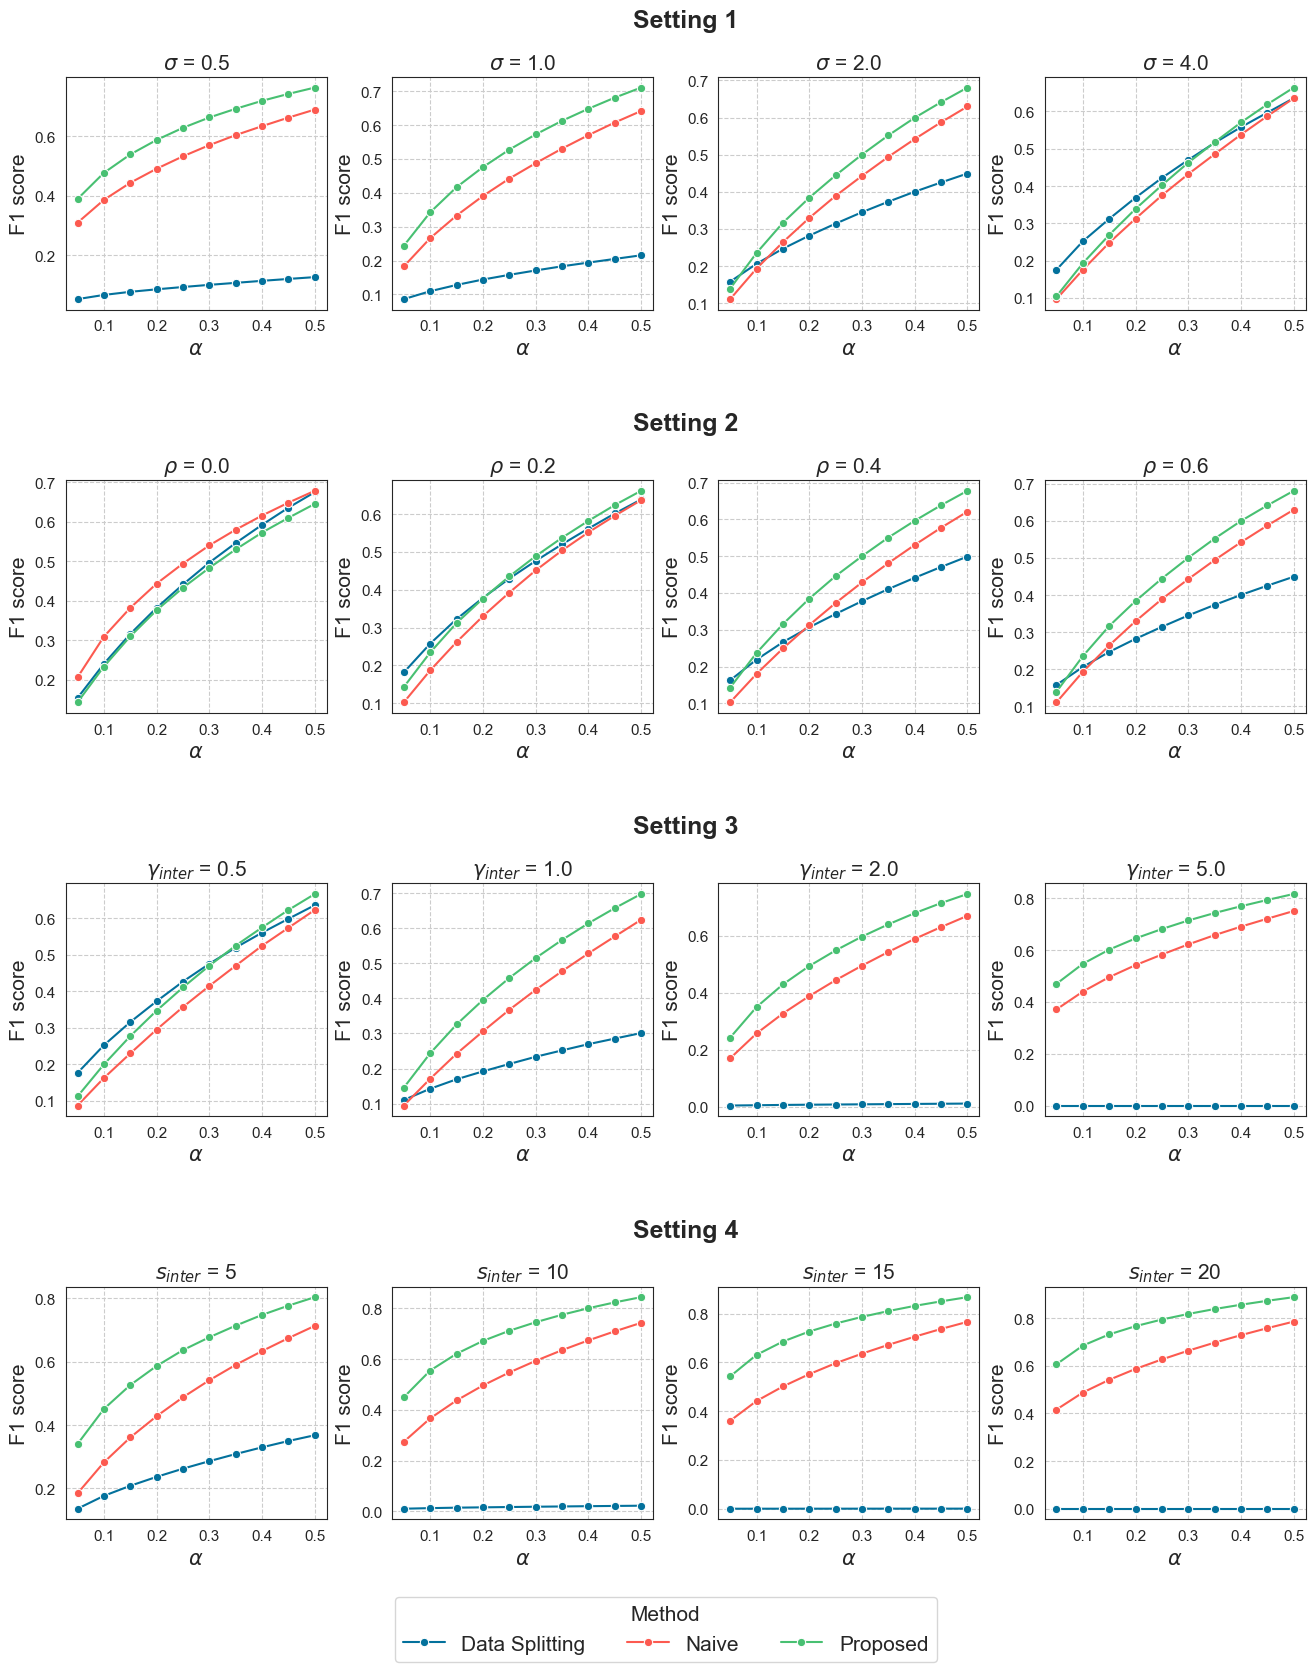

In [155]:
metric_by_alpha_plot_all(target_dict_list=[signal_results[2], 
                                           corr_results[2], 
                                           inter_results[2],
                                           sparsity_results[2]], 
                         threshold=0.1, 
                pval_key="pval", 
                parameter_names=[r"$\sigma$", r"$\rho$",
                                 r"$\gamma_{inter}$", r"$s_{inter}$"], 
                metric="F1",
                rank_def_count_list=[signal_results[1], 
                                           corr_results[1], 
                                           inter_results[1],
                                           sparsity_results[1]])